# Benchmarking Auto-Completion Models

This notebook compares various representations of the same model in order to investigate the benefits of quantisation and other optimisations, comparing performance of CPU- and GPU-based execution.

In [6]:
from time import time

import pandas as pd
import torch.cuda

from autodev.util import logging
from autodev.autocomplete.completion_model import CompletionModel
from autodev.autocomplete.completion_task import CompletionTask
from autodev.autocomplete.model import SantaCoderModelFactory, ModelTransformationBetterTransformer, \
    ModelTransformation

log = logging.getLogger(__name__)
logging.configure()

In [2]:
# configuration parameters
num_applications = 10
num_burnin_applications = 1

In [3]:
# load completion tasks
prefix = "def add(x, y):\n"
completion_tasks = [CompletionTask(prefix, "", "python")]

In [5]:
# define models to be benchmarked
mf = SantaCoderModelFactory()
tokenizer = mf.create_tokenizer()

def create_model(path, device, nocache=False, transform: ModelTransformation = None):
    model = mf.create_model(path, transformation=transform)
    if nocache:
        if model.config.use_cache:
            model.config.use_cache = False
        else:
            raise ValueError("Model does not use cache to begin with")
    return CompletionModel(model, tokenizer, device=device)

transformers_model_path = "bigcode/santacoder"
onnx_model_path = "models/santacoder_onnx"
onnx_avx2_model_path = "models/santacoder_onnx_avx2"
onnx_avx512_model_path = "models/santacoder_onnx_avx512"
bt = ModelTransformationBetterTransformer()
models = {
    "transformers-cached-cpu": (lambda: create_model(transformers_model_path, "cpu")),
    "transformers-cpu": (lambda: create_model(transformers_model_path, "cpu", nocache=True)),
    "onnxruntime-cpu": (lambda: create_model(onnx_model_path, "cpu")),
    "onnxruntime-cpu-avx2": (lambda: create_model(onnx_avx2_model_path, "cpu")),
    "onnxruntime-cpu-avx512": (lambda: create_model(onnx_avx512_model_path, "cpu")),
    "bettertransformer-cached-cpu": (lambda: create_model(transformers_model_path, "cpu", transform=bt)),
}
if torch.cuda.is_available():
    device = "cuda:0"
    models.update({
        "transformers-cached-gpu": (lambda: create_model(transformers_model_path, device)),
        "transformers-gpu": (lambda: create_model(transformers_model_path, device, nocache=True)),
        "onnxruntime-gpu": (lambda: create_model(onnx_model_path, device)),
        "bettertransformer-cached-gpu": (lambda: create_model(transformers_model_path, device, transform=bt)),
    })

In [9]:
# apply benchmarking
rows = []
for model_name, cm_factory in models.items():
    log.info(f"Starting evaluation of {model_name}")
    tstart = time()
    completion_model: CompletionModel = cm_factory()
    load_time = time() - tstart
    num_chars = 0
    for i in range(num_applications + num_burnin_applications):
        if i == num_burnin_applications:
            tstart = time()
            num_chars = 0
        for completion_task in completion_tasks:
            result = completion_model.apply(completion_task)
            num_chars += len(result.completion)
    time_taken = time() - tstart
    log.info(f"{model_name}: time taken = {time_taken}s")
    rows.append(dict(model_name=model_name, time_taken=time_taken, num_chars=num_chars,
        secs_per_task=time_taken/(num_applications*len(completion_tasks)), load_time=load_time))
    del completion_model

INFO  2023-07-08 10:33:35,642 __main__:<module> - Starting evaluation of transformers-cached-cpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-08 10:34:26,059 __main__:<module> - transformers-cached-cpu: time taken = 24.619626760482788 ms
INFO  2023-07-08 10:34:26,245 __main__:<module> - Starting evaluation of transformers-cpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-08 10:35:44,983 __main__:<module> - transformers-cpu: time taken = 54.448054790496826 ms
INFO  2023-07-08 10:35:45,155 __main__:<module> - Starting evaluation of onnxruntime-cpu
INFO  2023-07-08 10:35:45,158 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx/model.onnx
INFO  2023-07-08 10:36:34,361 __main__:<module> - onnxruntime-cpu: time taken = 30.478903770446777 ms
INFO  2023-07-08 10:36:34,363 __main__:<module> - Starting evaluation of onnxruntime-cpu-avx2
INFO  2023-07-08 10:36:34,364 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx_avx2/model_quantized.onnx
INFO  2023-07-08 10:37:24,995 __main__:<module> - onnxruntime-cpu-avx2: time taken = 35.74293828010559 ms
INFO  2023-07-08 10:37:24,997 __main__:<module> - Starting evaluation of onnxruntime-cpu-avx512
INFO  2023-07-08 10:37:25,001 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx_avx512/model_qua

The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-08 10:38:43,826 __main__:<module> - bettertransformer-cached-cpu: time taken = 22.00521445274353 ms
INFO  2023-07-08 10:38:43,827 __main__:<module> - Starting evaluation of transformers-cached-gpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-08 10:39:13,912 __main__:<module> - transformers-cached-gpu: time taken = 6.1361541748046875 ms
INFO  2023-07-08 10:39:13,915 __main__:<module> - Starting evaluation of transformers-gpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-08 10:39:40,905 __main__:<module> - transformers-gpu: time taken = 5.971394300460815 ms
INFO  2023-07-08 10:39:40,908 __main__:<module> - Starting evaluation of onnxruntime-gpu
INFO  2023-07-08 10:39:40,910 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx/model.onnx


2023-07-08 10:39:50.939008341 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-07-08 10:39:50.939101797 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


INFO  2023-07-08 10:39:56,459 __main__:<module> - onnxruntime-gpu: time taken = 3.172605276107788 ms
INFO  2023-07-08 10:39:56,461 __main__:<module> - Starting evaluation of bettertransformer-cached-gpu
WARNING 2023-07-08 10:40:15,701 root:transform - For training, the BetterTransformer implementation for gpt2  architecture currently does not support padding as fused kernels do not support custom attention masks. Beware that passing padded batched training data may result in unexpected outputs.


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-08 10:40:22,962 __main__:<module> - bettertransformer-cached-gpu: time taken = 5.61237359046936 ms


In [11]:
df = pd.DataFrame(rows)
df.sort_values("secs_per_task", inplace=True)
df

,model_name,time_taken,num_chars,secs_per_task,load_time
8,onnxruntime-gpu,3.172605,360,0.317261,12.033145
9,bettertransformer-cached-gpu,5.612374,360,0.561237,20.310930
7,transformers-gpu,5.971394,360,0.597139,20.400416
6,transformers-cached-gpu,6.136154,360,0.613615,23.316469
4,onnxruntime-cpu-avx512,18.589226,360,1.858923,11.586149
5,bettertransformer-cached-cpu,22.005214,360,2.200521,22.455523
0,transformers-cached-cpu,24.619627,360,2.461963,23.292466
2,onnxruntime-cpu,30.478904,360,3.047890,15.587316
3,onnxruntime-cpu-avx2,35.742938,670,3.574294,11.277208
1,transformers-cpu,54.448055,360,5.444805,18.652644


INFO  2023-07-08 10:49:08,844 matplotlib.font_manager:_load_fontmanager - generated new fontManager


<Axes: xlabel='secs_per_task', ylabel='model_name'>

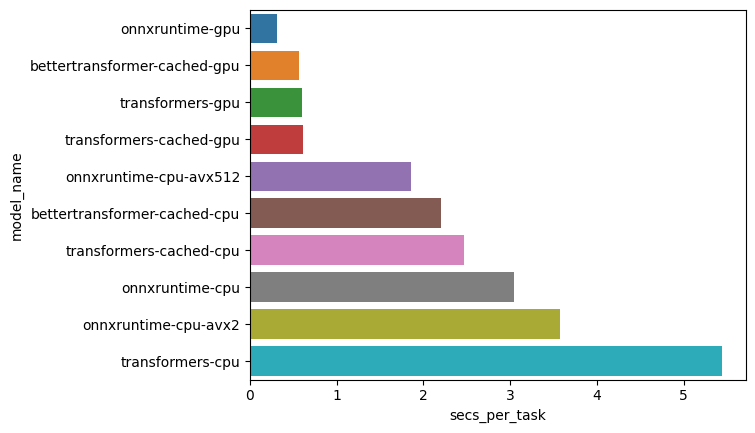

In [14]:
import seaborn as sns

sns.barplot(x="secs_per_task", y="model_name", data=df)